### Imports

In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.optimizers import Adam
import os
from PIL import Image
import pathlib
import random
# Metrics
from tensorflow.keras.metrics import *

# Part 1: Vizualisation

In [9]:
path = '/Users/martin/Documents/Cours/Data Mining/Projet/Dataset_BUSI_with_GT'
data_dir = pathlib.Path(path)
paths = glob("/Users/martin/Documents/Cours/Data Mining/Projet/Dataset_BUSI_with_GT/*/*")

In [10]:
class_names = os.listdir(data_dir)
print(class_names)

['malignant', 'benign', 'normal']


In [11]:
for class_name in class_names:
    images_count = len([i for i in paths if class_name in i and 'mask' not in i])
    masks_count = len([i for i in paths if class_name in i and 'mask' in i])
    print(f"{class_name} class has {images_count} images and {masks_count} masks.")

total_images = len([i for i in paths if 'mask' not in i])
total_masks = len([i for i in paths if 'mask' in i])
print(f"\nThere are total of {total_images} images and {total_masks} masks.")


malignant class has 210 images and 211 masks.
benign class has 437 images and 454 masks.
normal class has 133 images and 133 masks.

There are total of 780 images and 798 masks.


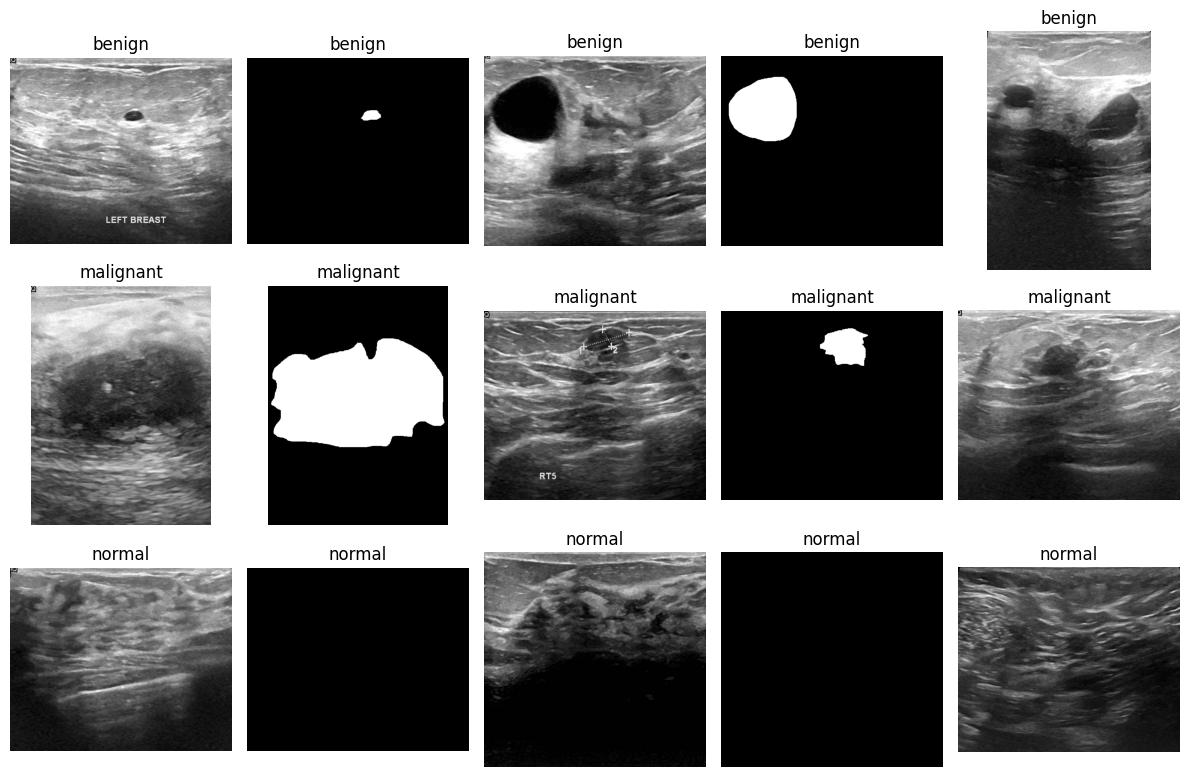

In [8]:
num_samples_per_class = 5 

fig, axes = plt.subplots(nrows=len(class_names), ncols=num_samples_per_class, figsize=(12, 8))

for i, class_name in enumerate(class_names):
    class_dir = data_dir / class_name
    images = list(class_dir.glob('*.png')) 
    sample_images = images[:num_samples_per_class]
    
    for j, image_path in enumerate(sample_images):
        image = Image.open(image_path)
        axes[i, j].imshow(image)
        axes[i, j].set_title(class_name)
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()

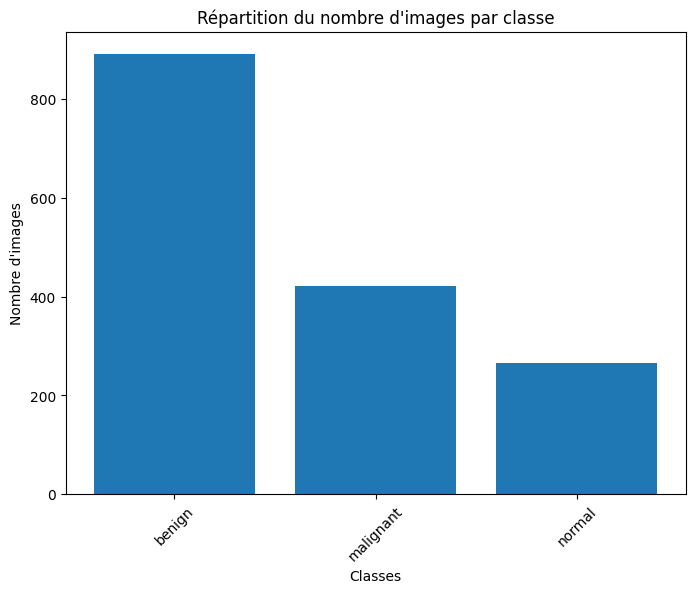

In [9]:
num_images_per_class = [len(list(class_dir.glob('*.png'))) for class_dir in data_dir.glob('*')]

plt.figure(figsize=(8, 6))
plt.bar(class_names, num_images_per_class)
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')
plt.title('Répartition du nombre d\'images par classe')
plt.xticks(rotation=45)
plt.show()

A class imbalance appears. This imbalance makes modelling the problem more difficult. We need to be careful that the model does not over-represent the majority classes and under-represent the minority classes.

In [12]:
# Afficher des stats
image_sizes = [Image.open(image_path).size for class_dir in data_dir.glob('*') for image_path in class_dir.glob('*.png')]
image_sizes = np.array(image_sizes)
print("Summary statistics on image size:")
print("Average image width :", np.mean(image_sizes[:, 0]))
print("Average image height:", np.mean(image_sizes[:, 1]))
print("Standard deviation of image width:", np.std(image_sizes[:, 0]))
print("Standard deviation of image height:", np.std(image_sizes[:, 1]))

Summary statistics on image size:
Average image width : 616.0804816223067
Average image height: 501.58681875792144
Standard deviation of image width: 122.03015163477556
Standard deviation of image height: 76.58474685664521


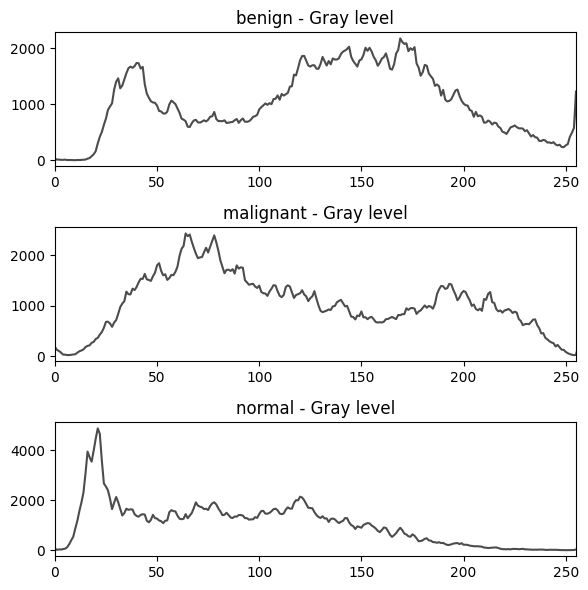

In [30]:
# Fonction pour calculer l'histogramme de niveaux de gris d'une image
def compute_grayscale_histogram(image):
    histogram = image.histogram()
    return histogram

# Calculer les histogrammes de niveaux de gris pour chaque classe d'images
histograms_per_class = {}
for class_name in class_names:
    class_dir = data_dir / class_name
    images = [Image.open(image_path) for image_path in class_dir.glob('*.png')]
    class_histograms = []
    for image in images:
        grayscale_hist = compute_grayscale_histogram(image)
        class_histograms.append(grayscale_hist)
    histograms_per_class[class_name] = class_histograms

# Afficher les histogrammes de niveaux de gris pour chaque classe
fig, axes = plt.subplots(nrows=len(class_names), ncols=1, figsize=(6, 6))

for i, class_name in enumerate(class_names):
    grayscale_histograms = histograms_per_class[class_name]
    axes[i].plot(grayscale_histograms[0], color='black', alpha=0.7)
    axes[i].set_title(f"{class_name} - Gray level")
    axes[i].set_xlim([0,255])

plt.tight_layout()
plt.show()


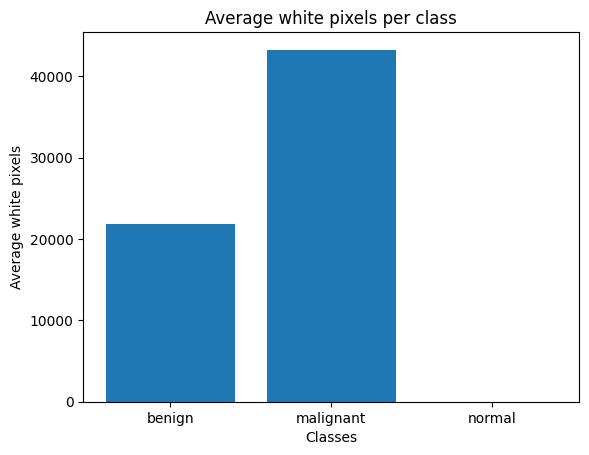

In [33]:
def compute_average_white_pixels(class_name, masks_dir):
    masks = [Image.open(os.path.join(masks_dir, mask_file)) for mask_file in os.listdir(masks_dir) if "mask" in mask_file.lower()]
    num_masks = len(masks)
    white_pixel_counts = []
    for mask in masks:
        mask_array = np.array(mask)
        white_pixel_count = np.sum(mask_array > 0)  # Count the white pixels (non-black) in the mask
        white_pixel_counts.append(white_pixel_count)

    average_white_pixels = np.mean(white_pixel_counts)
    return average_white_pixels

def plot_average_white_pixels(data_dir, class_names):
    average_white_pixels_per_class = []
    for class_name in class_names:
        class_dir_mask = os.path.join(data_dir, class_name)
        average_white_pixels = compute_average_white_pixels(class_name, class_dir_mask)
        average_white_pixels_per_class.append(average_white_pixels)

    # Créer le graphique
    plt.bar(class_names, average_white_pixels_per_class)
    plt.xlabel('Classes')
    plt.ylabel('Average white pixels')
    plt.title('Average white pixels per class')
    plt.show()

# Appeler la fonction pour afficher le graphique
plot_average_white_pixels(data_dir, class_names)

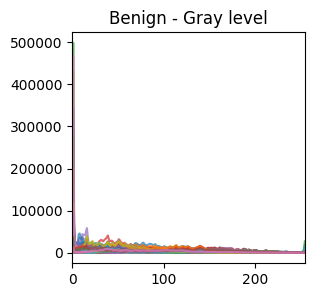

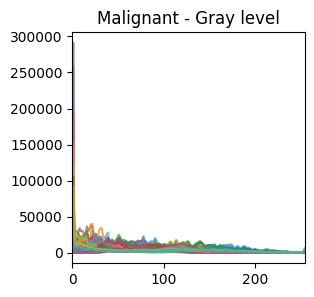

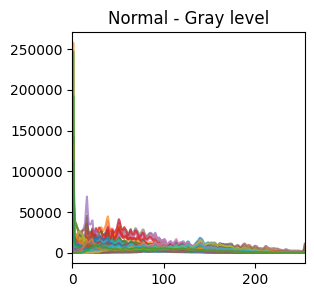

In [34]:
def compute_grayscale_histogram(image):
    image_array = np.array(image)
    histogram, _ = np.histogram(image_array.ravel(), bins=256, range=(0, 256))
    return histogram

def plot_histograms(class_type, class_name, images):
    plt.figure(figsize=(3,3))
    for image in images:
        grayscale_hist = compute_grayscale_histogram(image)
        plt.plot(grayscale_hist, alpha=0.7)
    plt.title(f"{class_name.capitalize()} - Gray level")
    plt.xlim([0, 255])
    plt.show()

def visualize_masks(data_dir, class_names):
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        mask_files = [image_path for image_path in os.listdir(class_dir) if not "mask" in image_path.lower()]
        images_mask = [Image.open(os.path.join(class_dir, mask_file)) for mask_file in mask_files]
        plot_histograms("Mask", class_name, images_mask)

visualize_masks(data_dir, class_names)

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


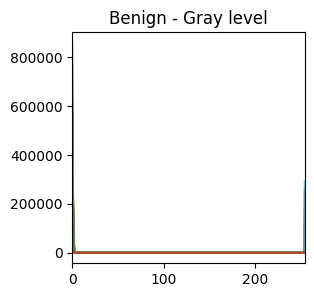

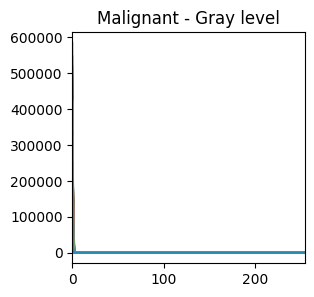

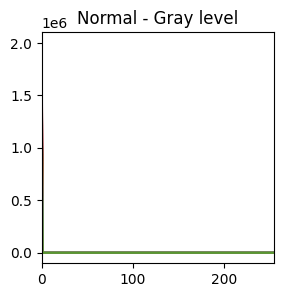

In [35]:
def compute_grayscale_histogram(image):
    image_array = np.array(image)
    histogram, _ = np.histogram(image_array.ravel(), bins=256, range=(0, 256))
    return histogram

def plot_histograms(class_type, class_name, images):
    plt.figure(figsize=(3,3))
    for image in images:
        grayscale_hist = compute_grayscale_histogram(image)
        plt.plot(grayscale_hist, alpha=0.7)
    plt.title(f"{class_name.capitalize()} - Gray level")
    plt.xlim([0, 255])
    plt.show()

def visualize_masks(data_dir, class_names):
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        mask_files = [image_path for image_path in os.listdir(class_dir) if "mask" in image_path.lower()]
        images_mask = [Image.open(os.path.join(class_dir, mask_file)) for mask_file in mask_files]
        plot_histograms("Mask", class_name, images_mask)

visualize_masks(data_dir, class_names)

# Part 2: Prepare the data for the model

In [12]:
# Test de différents paramètres
img_height = 180
img_width = 180
batch_size = 32

data_dir_train = "/Users/martin/Documents/Cours/Data Mining/Projet/Dataset_BUSI_with_GT"

In [13]:
# Appliquer l'augmentation des données au jeu d'entraînement
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

train_ds = train_datagen.flow_from_directory(
    data_dir_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_ds = train_datagen.flow_from_directory(
    data_dir_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

Found 1263 images belonging to 3 classes.
Found 315 images belonging to 3 classes.


# Part 3: Apply the models

###  - ResNet 50

In [14]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3), pooling='avg')

for layer in base_model.layers:
    layer.trainable = False

# BatchNormalization and Dropout added to prevent overlearning
model_resnet = Sequential()
model_resnet.add(base_model)
model_resnet.add(Dense(512, activation="tanh"))
model_resnet.add(BatchNormalization())
model_resnet.add(Dropout(0.5))
model_resnet.add(Dense(512, activation="tanh"))
model_resnet.add(BatchNormalization())
model_resnet.add(Dense(3, activation='softmax'))  # 3 classes : malignant, benign, normal

# Results
model_resnet.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_1 (Bat  (None, 512)               20

In [15]:
model_resnet.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

# ajuste automatiquement le learning rate (expliciter dans le rapport)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Entraîne le modèle en utilisant le générateur d'images augmentées
epochs = 30
history = model_resnet.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[reduce_lr])

Epoch 1/30
40/40 [==============================] - 105s 2s/step - loss: 1.1878 - accuracy: 0.5131 - val_loss: 1.0900 - val_accuracy: 0.2857 - lr: 0.0010
Epoch 2/30
40/40 [==============================] - 95s 2s/step - loss: 0.8875 - accuracy: 0.6033 - val_loss: 1.0296 - val_accuracy: 0.3873 - lr: 0.0010
Epoch 3/30
40/40 [==============================] - 101s 3s/step - loss: 0.7801 - accuracy: 0.6659 - val_loss: 1.1586 - val_accuracy: 0.5048 - lr: 0.0010
Epoch 4/30
40/40 [==============================] - 115s 3s/step - loss: 0.7499 - accuracy: 0.6683 - val_loss: 1.1822 - val_accuracy: 0.5460 - lr: 0.0010
Epoch 5/30
40/40 [==============================] - 114s 3s/step - loss: 0.7552 - accuracy: 0.6683 - val_loss: 0.9573 - val_accuracy: 0.6190 - lr: 0.0010
Epoch 6/30
40/40 [==============================] - 119s 3s/step - loss: 0.7205 - accuracy: 0.7007 - val_loss: 0.9233 - val_accuracy: 0.6603 - lr: 0.0010
Epoch 7/30
40/40 [==============================] - 116s 3s/step - loss: 0.73

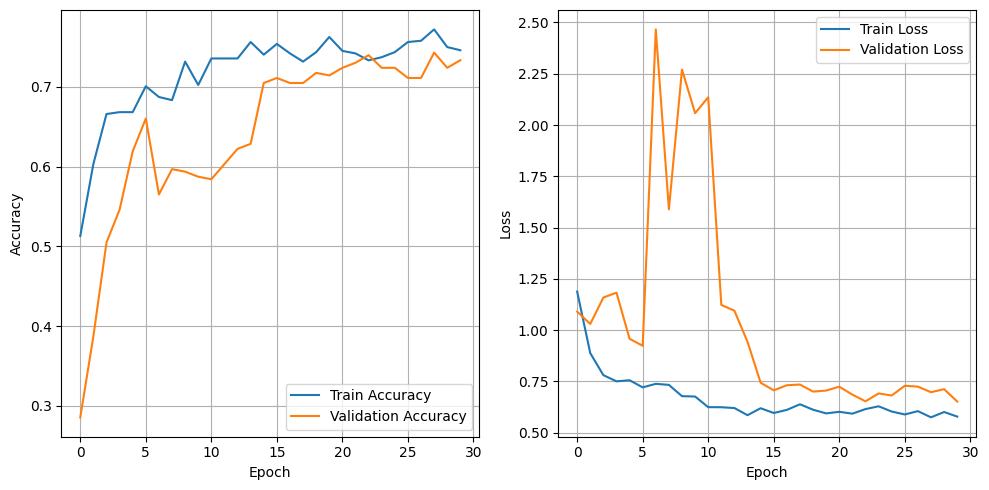

In [16]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## - U-Net

In [17]:
def load_image(path, size):
    image = cv2.imread(path)
    image = cv2.resize(image, (size,size))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image/255.   # normalize
    return image

def load_data(root_path, size):
    images = []
    masks = []
    
    x = 0 
    
    for path in sorted(glob(root_path)):
        img = load_image(path, size)   # read mask or image
            
        if 'mask' in path:
            if x:   #more than one maskss
                masks[-1] += img   # add the mask to the last mask
                    
                #reduce the range 0-1
                masks[-1] = np.array(masks[-1]>0.5, dtype='float64')
            else:
                masks.append(img)
                x = 1   # case if the image has a mask again
        else:
            images.append(img)
            x = 0   # for moving to the next image
    return np.array(images), np.array(masks)

In [20]:
size = 128   # image size: 128x128
X, y = load_data(root_path = '/Users/martin/Documents/Cours/Data Mining/Projet/Dataset_BUSI_with_GT/*/*', size = size)

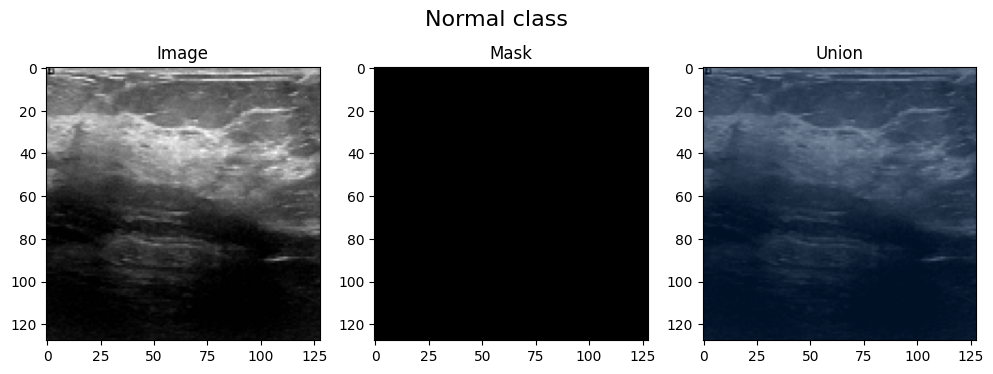

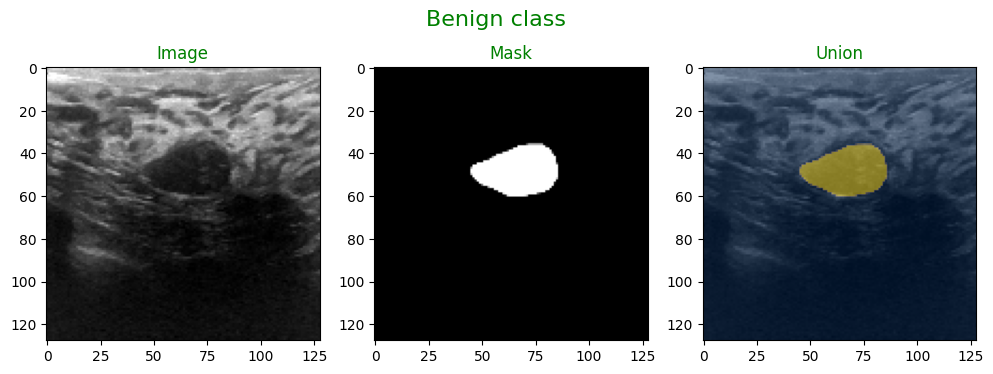

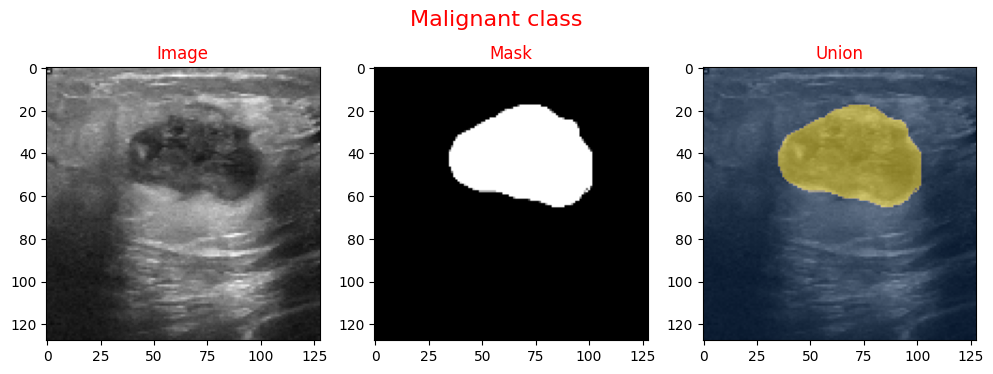

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def display_images_and_masks(X, y, title, title_color):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    # Randomly selection
    if title == 'Normal class':
        i = np.random.randint(647, 780)
    elif title == 'Benign class':
        i = np.random.randint(437)
    else:  # Malignant class
        i = np.random.randint(437, 647)

    ax[0].imshow(X[i], cmap='gray')
    ax[0].set_title('Image', color=title_color)

    ax[1].imshow(y[i], cmap='gray')
    ax[1].set_title('Mask', color=title_color)

    ax[2].imshow(X[i], cmap='gray')
    ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='cividis')
    ax[2].set_title('Union', color=title_color)

    fig.suptitle(title, fontsize=16, color=title_color)
    plt.show()

display_images_and_masks(X, y, 'Normal class', 'black')
display_images_and_masks(X, y, 'Benign class', 'green')
display_images_and_masks(X, y, 'Malignant class', 'red')


In [22]:
# Drop normal class because normal class has no mask
X = X[:647]
y = y[:647]

# Expand dimensions for modeling
X = np.expand_dims(X, -1)
y = np.expand_dims(y, -1)
print(f"X shape: {X.shape}  |  y shape: {y.shape}")

X shape: (647, 128, 128, 1)  |  y shape: (647, 128, 128, 1)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [24]:
print(f'X_train shape:',{X_train.shape}, "y_train shape:",{y_train.shape}, "\n")
print(f'X_test shape:',{X_test.shape}, "y_test shape:",{y_test.shape})

X_train shape: {(549, 128, 128, 1)} y_train shape: {(549, 128, 128, 1)} 

X_test shape: {(98, 128, 128, 1)} y_test shape: {(98, 128, 128, 1)}


In [25]:
# conv_block: A block that applies two convolutional layers with ReLU activation for feature extraction
def conv_block(input, num_filters):
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(input)
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
    return conv

# encoder_block: A block that combines a convolutional block and max pooling to downsample the feature maps
def encoder_block(input, num_filters):
    conv = conv_block(input, num_filters)
    pool = MaxPooling2D((2, 2))(conv)
    return conv, pool

# decoder_block: A block that combines up-sampling, concatenation with skip connections, and a convolutional block to upsample the feature maps
def decoder_block(input, skip_features, num_filters):
    uconv = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    con = concatenate([uconv, skip_features])
    conv = conv_block(con, num_filters)
    return conv

In [26]:
def build_model(input_shape):
    input_layer = Input(input_shape)
    
    s1, p1 = encoder_block(input_layer, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    
    output_layer = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    
    model = Model(input_layer, output_layer, name="U-Net")
    return model

model_unet = build_model(input_shape=(size, size, 1))
model_unet.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])
model_unet.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         640       ['input_2[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [27]:
history = model_unet.fit(X_train, y_train, epochs = 15, validation_data = (X_test,y_test))

Epoch 1/15
18/18 [==============================] - 379s 20s/step - loss: 0.4959 - accuracy: 0.8672 - val_loss: 0.3274 - val_accuracy: 0.9154
Epoch 2/15
18/18 [==============================] - 361s 20s/step - loss: 0.3341 - accuracy: 0.9024 - val_loss: 0.3140 - val_accuracy: 0.9154
Epoch 3/15
18/18 [==============================] - 355s 20s/step - loss: 0.3216 - accuracy: 0.9024 - val_loss: 0.2947 - val_accuracy: 0.9154
Epoch 4/15
18/18 [==============================] - 355s 20s/step - loss: 0.2937 - accuracy: 0.9024 - val_loss: 0.2339 - val_accuracy: 0.9154
Epoch 5/15
18/18 [==============================] - 350s 19s/step - loss: 0.2413 - accuracy: 0.9032 - val_loss: 0.2084 - val_accuracy: 0.9181
Epoch 6/15
18/18 [==============================] - 349s 19s/step - loss: 0.2338 - accuracy: 0.9070 - val_loss: 0.2194 - val_accuracy: 0.9158
Epoch 7/15
18/18 [==============================] - 353s 20s/step - loss: 0.2489 - accuracy: 0.9032 - val_loss: 0.2322 - val_accuracy: 0.9170
Epoch 

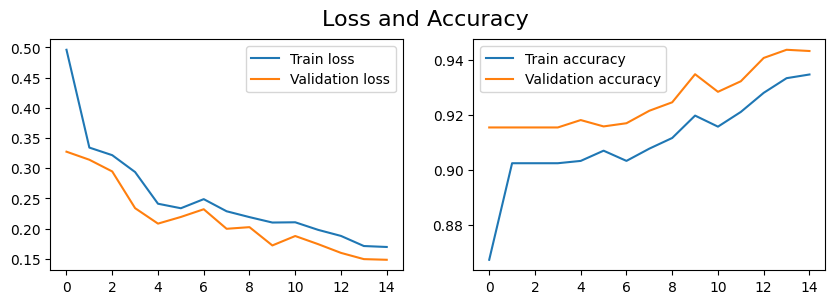

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax[1].legend()
fig.suptitle('Loss and Accuracy', fontsize=16)
plt.show()

# Part 4: Comparison of the two methods

10/10 [==============================] - 20s 2s/step - loss: 0.6916 - accuracy: 0.7270


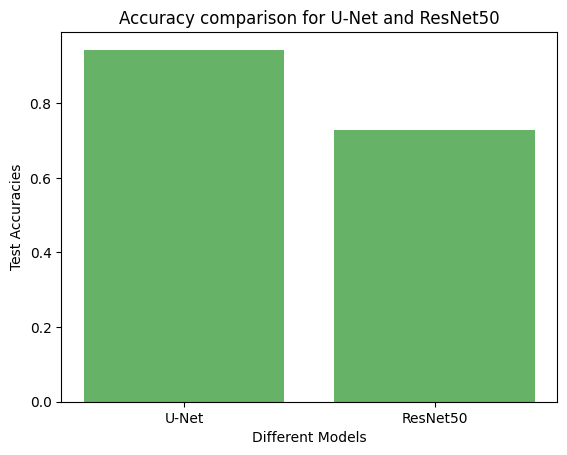

In [29]:
test_accs_unet = model_unet.evaluate(X_test, y_test)[1]   # Test accuracy for U-Net
test_accs_resnet = model_resnet.evaluate(val_ds)[1]       # Test accuracy for ResNet50


test_accs_data = pd.DataFrame({'test_accs': [test_accs_unet, test_accs_resnet],
                               'models': ['U-Net', 'ResNet50']})

# Plotting the bar chart
plt.bar(test_accs_data['models'], test_accs_data['test_accs'], facecolor='g', alpha=0.6)
plt.xlabel('Different Models')
plt.ylabel('Test Accuracies')
plt.title('Accuracy comparison for U-Net and ResNet50')
plt.show()
